In [2]:
import json

# loads the subset dataset created for analysis
# file = json.load(open('../data/subsets/visdial_1.0_train_100percent_subset.json'))
file = json.load(open('../data/v1.0/visdial_1.0_train.json'))
dialogs = file['data']['dialogs'] # dict_keys(['dialogs', 'answers', 'questions'])
# usage = file['volume']

In [3]:
# loading the train and val captions form the coco dataset
train_captions = json.load(open("../data/coco/annotations_trainval2014/annotations/captions_train2014.json")) # dict_keys(['info', 'images', 'licenses', 'annotations'])
val_captions = json.load(open("../data/coco/annotations_trainval2014/annotations/captions_val2014.json")) # dict_keys(['info', 'images', 'licenses', 'annotations'])
# Example entry from train/val annotations
train_captions['annotations'][0]

{'image_id': 318556,
 'id': 48,
 'caption': 'A very clean and well decorated empty bathroom'}

In [4]:
# quick check to make the max image id isn't greater than 6 characters
max([item['image_id'] for item in train_captions['annotations']+val_captions['annotations']])


581929

In [5]:
from pathlib import Path

# Storing the captions from visdial_1.0_train.json
image_ids = [item['image_id'] for item in dialogs]
# image_ids = [Path(item['image_id'][:-4][-6:]).name for item in dialogs] # the :-4 is to remove the .jpg extension and -6 is the relevant image id
captions = [item['caption'] for item in dialogs]

captions[:3]

['a person that is laying next to a dog',
 'a black and white photo of a man on a horse by stacks of crates',
 'a couple of people and some motor bikes']

In [6]:
'''Note: Number of problem pairs in 12 data-points were 257 without numbers being converted to words, i.e. visdial captions contain numbers from time to time
        Here we replace all numbers inside a string with their corresponding words:
        only numbers delimited by word boundaries, i.e. space, period, comma are considered for replacement'''

import re
from num2words import num2words
from tqdm import tqdm

for item in tqdm(captions):
    transformed_item = item
    numbers_in_sentences = re.findall(r'\b\d+\b', item)
    numbers_to_words = [num2words(int(item)) for item in numbers_in_sentences]
    for num, word in zip(numbers_in_sentences, numbers_to_words):
        transformed_item = transformed_item.replace(num, word)
    captions[captions.index(item)] = transformed_item

100%|██████████| 123287/123287 [02:06<00:00, 973.40it/s]


In [7]:
from tqdm import tqdm
from time import sleep

'''Problem pairs store the entries that have a mismatch between the caption list in coco and the caption from visdial:
    1. the indices of the captions
    2. the caption from visdial
    3. the caption list from coco'''
coco_captions = []
visdial_caption_index_in_coco = []
problem_pairs = []

for id, caption in zip(tqdm(image_ids), captions):
    relevant_captions_for_id = [index['caption'] for index in train_captions['annotations']+val_captions['annotations'] if index['image_id'] == int(id)]

    # removing the '.' at the end of the caption, converting it into lowercase, and removing any trailing spaces for all captions in coco
    captions_for_each_id = [str(item.replace(".", "").lower().rstrip()).replace('/', ' ') for item in relevant_captions_for_id]
    
    coco_captions.append(captions_for_each_id)

    if caption in captions_for_each_id:
        visdial_caption_index_in_coco.append(captions_for_each_id.index(caption))
    else:
        problem_pairs.append((id, caption, captions_for_each_id))


100%|██████████| 123287/123287 [2:14:16<00:00, 15.30it/s] 


In [8]:
# Example entry from coco_captions
coco_captions[:3]

[['a man laying in bed next to his dog',
  'a person that is laying next to a dog',
  'a shirtless man poses next to his dog',
  'a man is lying down on the bed looking',
  'a man with a beard without a shirt and a sleeping dog'],
 ['a man riding a horse next to a bunch of shipping boxes',
  'a black and white photo of a man on a horse by stacks of crates',
  'a man on a horse hands a banana to a fat man in overalls',
  'a policeman on a horse is surrounded by wooden boxes',
  'a man in uniform sitting on a horse with two other men standing nearby'],
 ['a couple of people and some motor bikes',
  'several parked motorcycles sitting parked beside a fence',
  'a couple of dirt bike motorcycles are parked',
  'bikes parked on the side of a street beside a fence',
  'group of motorcycles with a rider in the background']]

In [68]:
# number of captions in coco_captions containing more than 5 captions
more_than_5 = [item for item in coco_captions if len(item) > 5]
len(more_than_5)

328

In [70]:
len([item for item in coco_captions if len(item) < 5])

0

In [71]:
# count number of captions in coco_captions equal to 5, 6, and 7
len([item for item in coco_captions if len(item) == 5]), len([item for item in coco_captions if len(item) == 6]), len([item for item in coco_captions if len(item) == 7])

(122959, 324, 4)

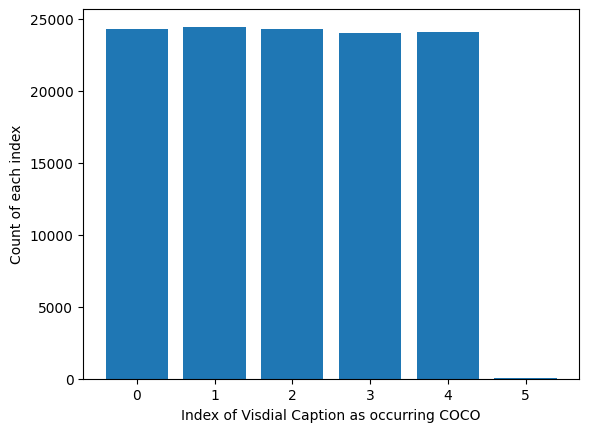

In [9]:
import matplotlib.pyplot as plt
import numpy as np

labels, counts = np.unique(visdial_caption_index_in_coco, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.xlabel('Index of Visdial Caption as occurring COCO', fontsize=10)
plt.ylabel('Count of each index', fontsize=10)
plt.show()

In [10]:
from scipy import stats
from statistics import mean

zscore_captions = stats.zscore(visdial_caption_index_in_coco)
np.mean(zscore_captions)

-4.3926549992102336e-17

In [11]:
# problems (apart from lowercase, trailing whitespace, periods, etc) because of other text artifacts when coco captions were used in visdial
print("Number of problem pairs in", round(len(dialogs)), "data-points are", len(problem_pairs))

Number of problem pairs in 123287 data-points are 2131


In [13]:
problem_pairs[:5]

[(36606,
  'people standing by a luggage carrousel for terminal four',
  ['two young men are waiting for their luggage',
   'people standing by a luggage carrousel for terminal 4',
   'the young men are waiting for their suitcases in the airport',
   'people waiting at the luggage carousel waiting for the bags to come',
   'people standing and waiting for their suitcase at an airport']),
 (359104,
  'a red white and black no parking sign posted on the front of another sign',
  ['a temporary sign for no parking is taped to a permanent street sign',
   'a red white and black no parking sign  posted on the front of another sign',
   'a paper no parking sign is taped to a road sign outside a high rise building',
   'a closeup of a sign being corrected with a piece of paper and tape',
   'a no parking sign underneath a street light next to a tall building']),
 (527748,
  'a picture of a cell phone showing the time as eight:fifty-six pm',
  ['a person is holding onto a cellphone somewhere',


In [54]:
subset_problem_pairs = []
for item in problem_pairs:
    x = item[2]
    # remove all double or triple spaces and replace them with single spaces
    x = [re.sub(r'\s+', ' ', item) for item in x]
    # replace all numbers in the list of sentences (item[2]) with their corresponding words
    x = [re.sub(r'\b\d+\b', lambda m: num2words(int(m.group(0))), item) for item in x]
    # if the first character of the sentence is a space, remove it
    x = [item[1:] if item[0] == " " else item for item in x]
    # remove ; and ' the sentences
    x = [item.replace(";", "").replace("'", "") for item in x]
    # replace @ with spaces
    x = [item.replace("@", " ") for item in x]
    # replace ? with ""
    x = [item.replace("?", "") for item in x]
    # check if item[1] is in x
    if item[1] not in x:
        subset_problem_pairs.append(item)

In [55]:
len(subset_problem_pairs)

170

In [52]:
subset_problem_pairs[:5]

[(287304,
  'this is an old subway car that’s pulled into the station',
  ['a close up of the side of an orange train',
   'the old subway has brass handles on it',
   'this is an old subway car thats pulled into the station',
   'a wooden set of doors with metal door handles',
   'a photo of the side of an old train car']),
 (152277,
  "a clock that's big hand is pointing at ten while the small is on twenty-two",
  ['an up close picture of a black and white clock',
   "a clock that's big hand is pointing at 10 while the small is on 22",
   'a white clock has black numbers and hands',
   'a large clock is close up in the picture',
   'a round quartz wall clock with white face and black hands at 10:22']),
 (113725,
  'a photo of a refrigerator in someone’s home',
  ['a refrigerator next to a long table and an office chair',
   'inside an office with a fridge and desk next to an open door',
   'the fridge is by the desk in the office',
   'a black lamp standing next to a white fridge',
 

In [56]:
from os import walk

# load the train images and their relative paths
coco_train_path = "../data/coco/train2014/"
coco_train = next(walk(coco_train_path), (None, None, []))[2]  # gives [] if no file
coco_train = list(map(lambda orig_string: coco_train_path + orig_string, coco_train)) # add relative path to each file name

# load the val images and their relative paths
coco_val_path = "../data/coco/val2014/"
coco_val = next(walk(coco_val_path), (None, None, []))[2]  # gives [] if no file
coco_val = list(map(lambda orig_string: coco_val_path + orig_string, coco_val)) # add relative path to each file name

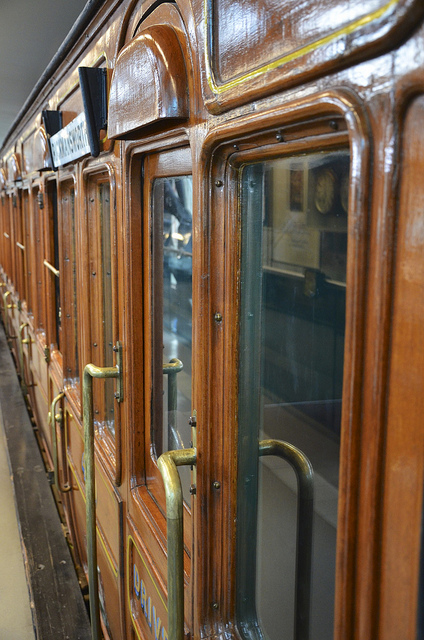

Visdial Caption: this is an old subway car that’s pulled into the station
Coco Captions: ['a close up of the side of an orange train', 'the old subway has brass handles on it', 'this is an old subway car thats pulled into the station', 'a wooden set of doors with metal door handles', 'a photo of the side of an old train car']


In [57]:
'''Check with images if visdial actually contains erroneous captions, since there's many captions where the visdial caption is not present in coco'''
from IPython.display import Image
from PIL import Image

def visualizer(id, visdial_caption, coco_captions):
        index = [idx for idx, s in enumerate(coco_train+coco_val) if str(id) in s][0]
        display(Image.open((coco_train+coco_val)[index]))
        print("Visdial Caption:", visdial_caption)
        print("Coco Captions:", coco_captions)


visualizer(subset_problem_pairs[0][0],
           subset_problem_pairs[0][1], subset_problem_pairs[0][2])


In [12]:
'''Given an image, check for similarity between all the alternative captions in the coco dataset and plot the variance
Reasoning: To investigate if there's a best caption selection from COCO that could have been used to augment Visdial model performance in some way'''

"Given an image, check for similarity between all the alternative captions in the coco dataset and plot the variance\nReasoning: To investigate if there's a best caption selection from COCO that could have been used to augment Visdial model performance in some way"

In [65]:
# find the index of example in coco captions
example = "a flock of birds flying in a blue sky"

for index, item in enumerate(coco_captions):
    if example in item:
        print(index)
        print(item)

120590
['a group of people flying many kites in the sky', 'a flock of birds flying in a blue sky', 'blue sky with flying persons and people walking below', 'a group of people in grassy area with kites in the sky', 'a colorful display of kites flying above a city park']


In [66]:
# find the index of example in coco captions
example = "a flock of birds flying in an overcast sky"

for index, item in enumerate(coco_captions):
    if example in item:
        print(index)
        print(item)


110481
['a flock of birds flying in an overcast sky', 'several birds are flying in a group across the sky', 'the flock of birds are traveling closely together in the sky', 'a large group of birds can be seen flying in the sky', 'looking up at a flock of small birds in the sky']
